# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import re
import pandas as pd
import glob
from pathlib import Path
import json
from shutil import copyfile
import itertools
from collections import Counter

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
# Spacy Imports
import spacy

from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.attrs import intify_attrs

def display_ent(doc):
    displacy.render(doc, style="ent", jupyter=True)

spacy_model = "en_core_web_lg"

nlp = spacy.load(spacy_model)

In [44]:
# User Source Code

import utils

In [59]:
# Project Base
base_path = Path('..')

# Data Paths
data_path = base_path / 'data'
all_reports_path = data_path / 'wamex_xml'
subset_reports_path = data_path / 'subset'

# Event Path
events_path = base_path / 'events'

# Dictionary Paths
dictionary_path = base_path / 'dictionary'
triggers_path = dictionary_path / 'triggers'
patterns_path = dictionary_path / 'patterns'

# NLP

## Load Patterns

In [72]:
patterns = []
for filename in patterns_path.iterdir():
    with open(filename, encoding="utf8") as f:
        patterns += json.load(f)
        
print(f'loaded {len(patterns)} patterns')

loaded 31120 patterns


In [22]:
patterns[:5]

[{'label': 'ROCK',
  'pattern': [{'LOWER': 'ï»¿acapulcoite'}, {'LOWER': 'meteorite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'aceite'}]},
 {'label': 'ROCK',
  'pattern': [{'LOWER': 'acid'}, {'LOWER': 'volcanic'}, {'LOWER': 'rock'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adakite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adamellite'}]}]

## Add patterns to nlp

In [73]:
ruler = EntityRuler(nlp, overwrite_ents=True)
ruler.add_patterns(patterns)

nlp.add_pipe(ruler)

## Load Trigger Words

In [74]:
trigger_words = []
for filename in triggers_path.iterdir():
    with open(filename, 'r') as f:
        trigger_words += [w.strip() for w in f.readlines()]
    
print(f'loaded {len(trigger_words)} trigger words\n')
print(trigger_words)

loaded 25 trigger words

['potential', 'drill', 'drilling', 'mineralisation', 'contain', 'promise', 'find', 'possible', 'enrich', 'enrichment', 'subeconomic', 'encouraging', 'extensive', 'patchy', 'minor', 'further drilling', 'low grade', 'medium grade', 'follow up', 'weak intercepts', 'minor intercepts', 'open at depth', 'along strike', 'exploration licence', 'prospective']


In [75]:
geology_ents = ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']

# Event Extraction

In [76]:
from utils import create_event_df

eventdf = create_event_df(
    nlp=nlp, 
    directory=subset_reports_path, 
    trigger_words=trigger_words, 
    n_sentences_extact=2
)

eventdf.head()

extracting events on 100 files
found 1580 events from a total of 7956 sentences


,event_id,filename,sentence_idx,sentence_text,n_trigger_words,trigger_words,event_text
0,a080918_e9_1443_annual_09_13904956_0,a080918_e9_1443_annual_09_13904956.json,0,following the completion of the hole and loggi...,1,[potential],following the completion of the hole and loggi...
1,a080918_e9_1443_annual_09_13904956_15,a080918_e9_1443_annual_09_13904956.json,15,photos of core c: yaringa e9_1443_annual_09.do...,1,[mineralisation],mineral drillholes data 2. lithology summary a...
2,a080918_e9_1443_annual_09_13904956_16,a080918_e9_1443_annual_09_13904956.json,16,several suitable target areas were identified ...,1,[exploration licence],lithology summary appendices 1. photos of core...
3,a080918_e9_1443_annual_09_13904956_18,a080918_e9_1443_annual_09_13904956.json,18,introduction the company has identified the on...,2,"[prospective, mineralisation]",several suitable target areas were identified ...
4,a080918_e9_1443_annual_09_13904956_19,a080918_e9_1443_annual_09_13904956.json,19,the gascoyne platform is a diamond shaped area...,1,[contain],this report details the work completed on one ...


## Save Events to csv file

In [60]:
event_path = events_path / 'group_0_events.csv'
eventdf.to_csv(event_path, index=False)

# Visualisations

## Frequency of number of trigger words found in each event

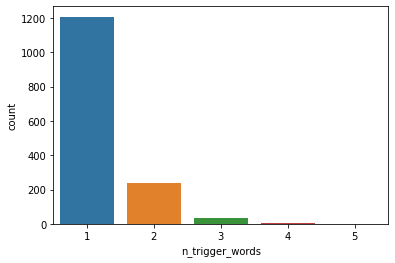

In [54]:
sns.countplot(eventdf.n_trigger_words);

## Count of each trigger word found

In [55]:
counts = Counter(list(itertools.chain(*eventdf.trigger_words.tolist())))
countsdf = (pd.DataFrame.from_dict(counts, orient='index')
            .reset_index()
            .rename(columns={'index':'trigger_word', 0:'count'})
            .sort_values('count', ascending=False)
           )
countsdf

,trigger_word,count
4,drill,466
1,mineralisation,421
0,potential,192
2,contain,169
5,minor,132
9,find,105
3,possible,73
8,follow up,67
6,extensive,60
18,along strike,36


In [70]:
example = nlp(eventdf.iloc[5]['event_text'])
display_ent(example)